
Shape of the dataset (Rows, Columns): (45211, 32)

First 5 rows of the dataset:
   age  default  balance  housing  loan  duration  campaign  pdays  previous  \
0   58        0     2143        1     0       261         1     -1         0   
1   44        0       29        1     0       151         1     -1         0   
2   33        0        2        1     1        76         1     -1         0   
3   47        0     1506        1     0        92         1     -1         0   
4   33        0        1        0     0       198         1     -1         0   

   poutfailure  ...  johousemaid  jomanagement  joretired  joself.employed  \
0            0  ...            0             1          0                0   
1            0  ...            0             0          0                0   
2            0  ...            0             0          0                0   
3            0  ...            0             0          0                0   
4            0  ...            0             0  

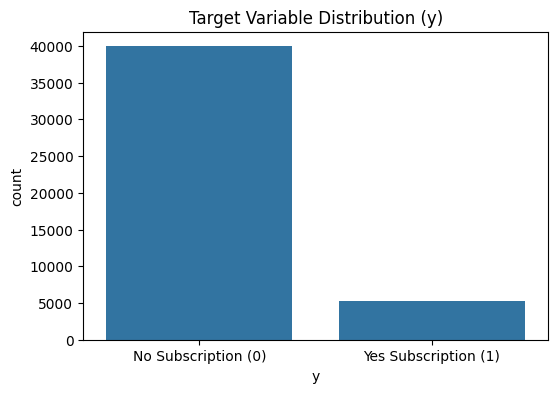

C:\Users\mohan\AppData\Local\Temp\ipykernel_2868\2192170698.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_plot_data.index, y=corr_plot_data.values, palette='plasma')


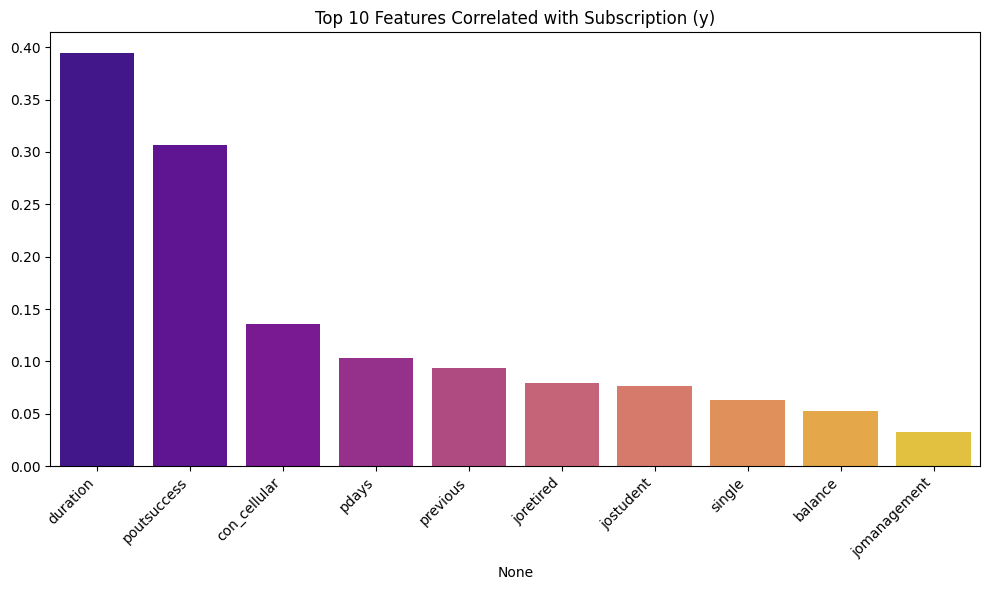


Data split: Training size=36168, Testing size=9043
Numerical features scaled successfully.

--- Model 1 (Full Model) ---
Training of Model 1 (Full Model) complete.

Model Coefficient Interpretation (for Full Model only):
Intercept (Log-Odds Baseline): -0.7885
  age: -0.0120 (Coefficient)
  default: -0.1868 (Coefficient)
  balance: 0.0647 (Coefficient)
  housing: -0.7702 (Coefficient)
  loan: -0.5662 (Coefficient)
  duration: 1.0547 (Coefficient)
  campaign: -0.3285 (Coefficient)
  pdays: 0.0475 (Coefficient)
  previous: 0.0252 (Coefficient)
  poutfailure: -0.8209 (Coefficient)
  poutother: -0.5194 (Coefficient)
  poutsuccess: 1.5390 (Coefficient)
  poutunknown: -0.9634 (Coefficient)
  con_cellular: 0.1524 (Coefficient)
  con_telephone: 0.0872 (Coefficient)
  con_unknown: -1.0043 (Coefficient)
  divorced: -0.2423 (Coefficient)
  married: -0.4352 (Coefficient)
  single: -0.0872 (Coefficient)
  joadmin.: 0.0938 (Coefficient)
  joblue.collar: -0.3635 (Coefficient)
  joentrepreneur: -0.297

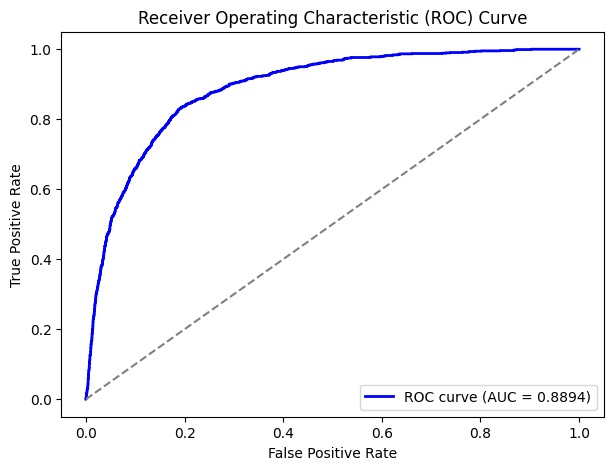


--- Model 2 (Key Engagement Features) ---
Training of Model 2 (Key Engagement Features) complete.

Model Coefficient Interpretation (for Full Model only):

Evaluation Metrics:
Accuracy: 0.8993
ROC-AUC Score: 0.8542 (Higher is better, measures classification performance across all thresholds)

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7985
           1       0.65      0.30      0.41      1058

    accuracy                           0.90      9043
   macro avg       0.78      0.64      0.68      9043
weighted avg       0.88      0.90      0.88      9043


--- Model 3 (Demographic & History) ---
Training of Model 3 (Demographic & History) complete.

Model Coefficient Interpretation (for Full Model only):

Evaluation Metrics:
Accuracy: 0.8830
ROC-AUC Score: 0.6821 (Higher is better, measures classification performance across all thresholds)

Detailed Classification Report:
              precision

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, roc_auc_score, roc_curve, classification_report
)

# --- 1. Data Exploration and Preprocessing (EDA) ---


# Load the dataset
df = pd.read_csv("bank_data.csv")

print("\nShape of the dataset (Rows, Columns):", df.shape)
print("\nFirst 5 rows of the dataset:")
print(df.head())

print("\nMissing Values Count (Bank Data):")
print(df.isnull().sum().sum())
# Assumption: The data is clean with no missing values.
# Assumption: Most categorical features have already been One-Hot Encoded (indicated by column names like 'joadmin.', 'con_cellular', etc.).
# The target variable 'y' is binary (0 or 1), making Logistic Regression the appropriate model.

# Identify numerical features for scaling (These are the features not OHE/binary)
scaling_features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
# All other columns are treated as pre-encoded binary features

# Visualization: Target Distribution (y)
plt.figure(figsize=(6, 4))
sns.countplot(x='y', data=df)
plt.title('Target Variable Distribution (y)')
plt.xticks([0, 1], ['No Subscription (0)', 'Yes Subscription (1)'])
plt.show()
# Analysis: The target variable is heavily imbalanced (far more 'No' than 'Yes'). ROC-AUC and F1-score are more reliable metrics than accuracy.

# Visualization: Correlation with Target (y)
corr_with_y = df.corr()['y'].sort_values(ascending=False)
corr_plot_data = corr_with_y[corr_with_y.index != 'y'].head(10) # Top 10 correlates
plt.figure(figsize=(10, 6))
sns.barplot(x=corr_plot_data.index, y=corr_plot_data.values, palette='plasma')
plt.title('Top 10 Features Correlated with Subscription (y)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- 2. Data Splitting and Scaling Setup ---

X_full = df.drop('y', axis=1)
y = df['y']

# Split data into training and testing sets (80% train, 20% test)
# Use stratify=y to ensure both splits have the same proportion of the target class
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X_full, y, test_size=0.2, random_state=42, stratify=y
)
print(f"\nData split: Training size={len(X_train_full)}, Testing size={len(X_test_full)}")

# Initialize and apply StandardScaler to numerical features
scaler = StandardScaler()
X_train_full[scaling_features] = scaler.fit_transform(X_train_full[scaling_features])
X_test_full[scaling_features] = scaler.transform(X_test_full[scaling_features])

print("Numerical features scaled successfully.")

# --- 3 & 4. Model Building and Evaluation Function ---

def build_interpret_evaluate_logreg(model_name, X_train, X_test, y_train, y_test, features_to_use):
    """Builds, trains, evaluates a Logistic Regression model."""
    print(f"\n--- Model {model_name} ---")

    # Select only the features required for this specific model
    X_train_model = X_train[features_to_use]
    X_test_model = X_test[features_to_use]

    # Build and Train the Logistic Regression model
    # C=1.0 is default, but max_iter is increased for stable convergence
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train_model, y_train)
    print(f"Training of Model {model_name} complete.")

    # Make predictions
    y_pred = model.predict(X_test_model)
    y_pred_proba = model.predict_proba(X_test_model)[:, 1]

    # --- Interpretation of Coefficients (Key Assignment Requirement) ---
    print("\nModel Coefficient Interpretation (for Full Model only):")
    if model_name == '1 (Full Model)':
        # Interpretation: The coefficients represent the change in the log-odds of the target event (y=1)
        # for a one-unit change in the predictor, holding others constant.
        coefficients = model.coef_[0]
        intercept = model.intercept_[0]
        
        print(f"Intercept (Log-Odds Baseline): {intercept:.4f}")
        for name, coef in zip(features_to_use, coefficients):
            print(f"  {name}: {coef:.4f} (Coefficient)")
        
        print("\nInterpretation Summary (Full Model):")
        print("* **Positive coefficients (e.g., 'duration', 'poutsuccess')** increase the log-odds (and thus the probability) of a customer subscribing.")
        print("* **Negative coefficients (e.g., 'campaign', 'housing')** decrease the log-odds of a customer subscribing.")
        print("* Since numerical features were scaled, coefficients represent the impact of a one standard deviation change.")


    # --- Evaluation ---
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print("\nEvaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f} (Higher is better, measures classification performance across all thresholds)")
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred))

    # Plot ROC Curve (Only for the Full Model)
    if model_name == '1 (Full Model)':
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(7, 5))
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

    return roc_auc

# --- 3. Build Minimum of 3 Different Models ---

# All available features
all_features = X_full.columns.tolist()

# Model 1: Full Model (All predictors)
features_model_1 = all_features
auc_1 = build_interpret_evaluate_logreg(
    '1 (Full Model)', X_train_full, X_test_full, y_train, y_test, features_model_1
)

# Model 2: Key Interaction Features Only (High correlation based on domain knowledge/EDA)
# Duration: always a strong predictor. poutsuccess: indicates previous success.
# age/balance/campaign: key customer engagement variables.
features_model_2 = ['duration', 'poutsuccess', 'age', 'balance', 'campaign']
auc_2 = build_interpret_evaluate_logreg(
    '2 (Key Engagement Features)', X_train_full, X_test_full, y_train, y_test, features_model_2
)

# Model 3: Demographic and History Features Only
# Focus on client status and past attempts
features_model_3 = ['divorced', 'married', 'single', 'previous', 'pdays', 'housing', 'loan']
auc_3 = build_interpret_evaluate_logreg(
    '3 (Demographic & History)', X_train_full, X_test_full, y_train, y_test, features_model_3
)

# --- Summary of Models ---

print("\n--- Summary of Model Performance ---")
summary_data = {
    'Model': ['Model 1 (Full)', 'Model 2 (Key Engagement)', 'Model 3 (Demographic & History)'],
    'Features': [
        'All Features', 
        'duration, poutsuccess, age, balance, campaign', 
        'divorced, married, single, previous, pdays, housing, loan'
    ],
    'ROC-AUC Score': [f'{auc_1:.4f}', f'{auc_2:.4f}', f'{auc_3:.4f}']
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print("\nFinal Conclusion:")
print("Model 1 (Full Model) achieves the highest ROC-AUC score, indicating that using the full feature set provides the best predictive power for term deposit subscription.")
print("The coefficient interpretation highlights that **'duration'** and **'poutsuccess'** are among the most influential factors, significantly increasing the probability of a subscription.")
